# Relax, Inc. Take-Home Data Science Challenge

**Prompt:** Defining an *"adopted user"* as a user who *has logged into the product on three separate days in at least one seven-day period*, **identify which factors predict future user adoption.**

More details in acompanying PDF [here](https://github.com/kstoudt/Springboard/blob/main/27.2%20The%20Take-Home%20Challenge/relax_challenge/relax_data_science_challenge.pdf)

In [1]:
import os
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
# warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
os.listdir()[2:]

['Relax Inc Data Science Challenge.ipynb',
 'relax_data_science_challenge.pdf',
 'takehome_users.csv',
 'takehome_user_engagement.csv']

# Exploring tabular data

In [3]:
# Discovering encoding type: Open .csv in Notepad->'save as'->check encoding suggestion
users_df = pd.read_csv('takehome_users.csv', index_col='object_id', encoding='ANSI')
users_df.head()

,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
object_id,,,,,,,,,
1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


**Future Scope - Feature Engineering:**
- Could build categorical column for 'email domain', pulling out websites (yahoo, gustr, gmail etc.)
- Could also append info of user who invited via 'invited_by_user_id'
 - Would be valuable to append some form of 'engagement level' of referring user. Perhaps, mailing list opt-ins, or 'marketing drip enabled'.
 - Furthermore, we could construct a column that represents the engagement or subscription level of a certain org_id so that when a user is invited, odds of becoming an 'adopted user' increase based on what we have seen, historically, from the org ('adopted user' % per org).

In [4]:
users_df['last_session_creation_time'] = pd.to_datetime(users_df['last_session_creation_time'], 
                                                        unit='s')
users_df['creation_time'] = pd.to_datetime(users_df['creation_time'])
users_df['invited_by_user_id'] = users_df['invited_by_user_id'].astype(int, errors='ignore').fillna(0)

# define 'usage_history' as last session time - creation time
users_df['usage_history'] = users_df['last_session_creation_time'] - users_df['creation_time']
users_df['usage_history'] = users_df['usage_history'].dt.days
users_df['usage_history'] = users_df['usage_history'].fillna(0).astype(int)

# Using latest 'last session creation' as 'pull date'
latest = max(users_df['last_session_creation_time'])

users_df['account_age'] = latest - users_df['creation_time']
users_df['account_age'] = users_df['account_age'].dt.days

users_df = users_df.drop(columns=['creation_time', 'last_session_creation_time', 'name', 'email'])
users_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,usage_history,account_age
object_id,,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0,45
2,ORG_INVITE,0,0,1,316.0,136,203
3,ORG_INVITE,0,0,94,1525.0,0,443
4,GUEST_INVITE,0,0,1,5151.0,1,381
5,GUEST_INVITE,0,0,193,5240.0,5,505


In [5]:
users_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             12000 non-null  object 
 1   opted_in_to_mailing_list    12000 non-null  int64  
 2   enabled_for_marketing_drip  12000 non-null  int64  
 3   org_id                      12000 non-null  int64  
 4   invited_by_user_id          12000 non-null  float64
 5   usage_history               12000 non-null  int32  
 6   account_age                 12000 non-null  int64  
dtypes: float64(1), int32(1), int64(4), object(1)
memory usage: 703.1+ KB


Note: 12,000 total registered users in this dataset.

# Target variable construction

In [6]:
logins_df = pd.read_csv('takehome_user_engagement.csv')
logins_df.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [7]:
logins_df['time_stamp'] = pd.to_datetime(logins_df['time_stamp'])

In [8]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   time_stamp  207917 non-null  datetime64[ns]
 1   user_id     207917 non-null  int64         
 2   visited     207917 non-null  int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 4.8 MB


**Note:** 'visited' is column of 1s ... good for .sum() to get counts

In [9]:
logins_df.duplicated().sum()

0

In [10]:
len(logins_df.user_id.value_counts())

8823

In [11]:
gr = logins_df.groupby(by=['user_id']).sum()
gr = gr[gr['visited'] > 2]
print(gr.head())
len(gr.index)

         visited
user_id         
2             14
10           284
20             7
33            18
42           342


2248

Here we see that, of 8,823 unique users in the 'logins' dataset, only 2,248 have a TOTAL login count of 3+ (about 25% of user_ids)

In [12]:
print(len(logins_df))
logins_df.head()

207917


,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [13]:
# Use timedelta object to measure week against '3 login window'

def adopted_filter(df, days=7, logins=3):
    df['date'] = df['time_stamp'].dt.date
    df = df.drop_duplicates(subset='date').sort_values('date')
    passed_days = df['date'].diff(periods=logins-1)
    return any(passed_days <= timedelta(days=days))

# returns True if any '3 login window per user' less than 1 week

In [14]:
adopted = logins_df.groupby('user_id').apply(adopted_filter)

print('{} adopted users out of {} total users'.format(sum(adopted), len(adopted)))

1656 adopted users out of 8823 total users


In [15]:
type(adopted)

pandas.core.series.Series

In [16]:
model_data = pd.concat([users_df, adopted], axis=1, join='inner')
# inner join filters for only users who we have login data for
model_data = model_data.rename(columns={0:'adopted'})
model_data['adopted'] = model_data['adopted'].astype(int)
model_data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,usage_history,account_age,adopted
1,GUEST_INVITE,1,0,11,10803.0,0,45,0
2,ORG_INVITE,0,0,1,316.0,136,203,1
3,ORG_INVITE,0,0,94,1525.0,0,443,0
4,GUEST_INVITE,0,0,1,5151.0,1,381,0
5,GUEST_INVITE,0,0,193,5240.0,5,505,0


In [17]:
model_data.describe()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,usage_history,account_age,adopted
count,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000,8823.000000
mean,0.252295,0.151989,142.572254,3237.316786,59.222147,322.466508,0.187691
std,0.434354,0.359031,124.176422,3888.088044,144.172167,215.987805,0.390488
min,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,0.000000
25%,0.000000,0.000000,30.000000,0.000000,0.000000,127.000000,0.000000
50%,0.000000,0.000000,109.000000,1055.000000,1.000000,300.000000,0.000000
75%,1.000000,0.000000,239.000000,6405.000000,20.000000,503.000000,0.000000
max,1.000000,1.000000,416.000000,11999.000000,729.000000,736.000000,1.000000


In [18]:
print('Pos class pct: {}'.format(round(100*model_data.adopted.describe()['mean'], 2)))

Pos class pct: 18.77


# Modeling / Feature Importances

In [19]:
from sklearn.model_selection import GridSearchCV, train_test_split
# from sklearn.preprocessing import StandardScaler # won't need to be scaling
# some numeric, some categorical data; small dataset:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, plot_roc_curve

In [20]:
model_data.keys()

Index(['creation_source', 'opted_in_to_mailing_list',
       'enabled_for_marketing_drip', 'org_id', 'invited_by_user_id',
       'usage_history', 'account_age', 'adopted'],
      dtype='object')

In [21]:
model_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8823 entries, 1 to 12000
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   creation_source             8823 non-null   object 
 1   opted_in_to_mailing_list    8823 non-null   int64  
 2   enabled_for_marketing_drip  8823 non-null   int64  
 3   org_id                      8823 non-null   int64  
 4   invited_by_user_id          8823 non-null   float64
 5   usage_history               8823 non-null   int32  
 6   account_age                 8823 non-null   int64  
 7   adopted                     8823 non-null   int32  
dtypes: float64(1), int32(2), int64(4), object(1)
memory usage: 551.4+ KB


In [22]:
model_data = model_data.drop(columns=['org_id', 'invited_by_user_id'])

In [23]:
model_data_1 = pd.get_dummies(model_data, drop_first=True)
model_data_1.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,usage_history,account_age,adopted,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
1,1,0,0,45,0,0,0,0,0
2,0,0,136,203,1,1,0,0,0
3,0,0,0,443,0,1,0,0,0
4,0,0,1,381,0,0,0,0,0
5,0,0,5,505,0,0,0,0,0


In [24]:
y = model_data_1[['adopted']].values.ravel()
X = model_data_1.drop(columns=['adopted'])

X.shape, y.shape

((8823, 8), (8823,))

In [25]:
X_tr, X_te, y_tr, y_te = train_test_split(X, y, stratify=y, test_size=1/3, random_state=42)
X_tr.shape, X_te.shape, y_tr.shape, y_te.shape

((5882, 8), (2941, 8), (5882,), (2941,))

In [26]:
clf = RandomForestClassifier(random_state=42)

param_grid = {'n_estimators':[10, 50, 100, 200],
             'criterion':['gini','entropy']}

cvmod = GridSearchCV(clf, param_grid, scoring='f1_weighted', cv=5)

cvmod.fit(X_tr, y_tr)

print('Best params:', cvmod.best_params_)
print('Best score:', cvmod.best_score_)

Best params: {'criterion': 'entropy', 'n_estimators': 100}
Best score: 0.9620184209152889


In [27]:
model = RandomForestClassifier(criterion='entropy', n_estimators=100, random_state=42)

model.fit(X_tr, y_tr)
y_pred = model.predict(X_te)

print('roc_auc:', roc_auc_score(y_te, y_pred))
print(classification_report(y_te, y_pred))

roc_auc: 0.9265481585285215
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2389
           1       0.91      0.87      0.89       552

    accuracy                           0.96      2941
   macro avg       0.94      0.93      0.93      2941
weighted avg       0.96      0.96      0.96      2941



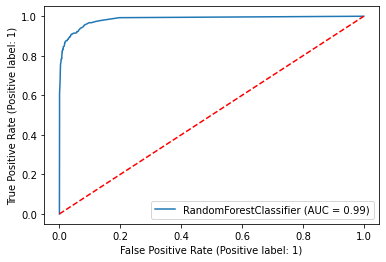

In [28]:
warnings.simplefilter(action='ignore', category= FutureWarning)

_ = plot_roc_curve(model, X_te, y_te, pos_label=1)
plt.plot([0, 1], [0, 1], 'r--')
plt.show();

In [29]:
features = X_tr.keys()
imps = model.feature_importances_.ravel()
imp_df = pd.DataFrame((zip(features, imps)), columns =['Features', 'Importance scores'])
imp_df = imp_df.sort_values('Importance scores', ascending=False)
print(imp_df)

                             Features  Importance scores
2                       usage_history           0.868280
3                         account_age           0.110892
0            opted_in_to_mailing_list           0.004787
4          creation_source_ORG_INVITE           0.003882
6              creation_source_SIGNUP           0.003604
1          enabled_for_marketing_drip           0.003526
5   creation_source_PERSONAL_PROJECTS           0.002526
7  creation_source_SIGNUP_GOOGLE_AUTH           0.002503


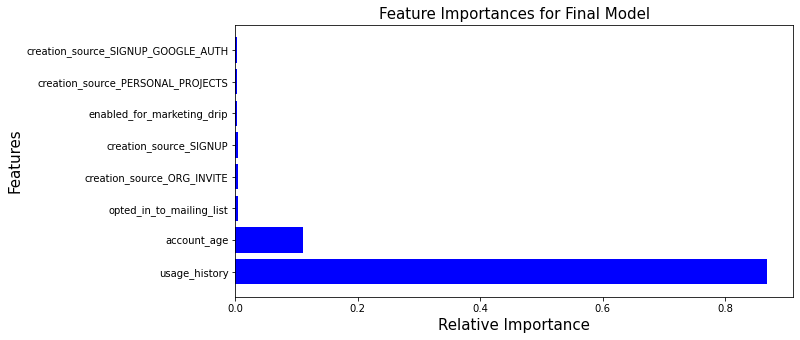

In [30]:
plt.figure(figsize=(10,5))
_=plt.barh(imp_df['Features'], imp_df['Importance scores'], align='center', color='b')
plt.xlabel('Relative Importance',fontsize=15)
plt.ylabel('Features',fontsize=15)
plt.title('Feature Importances for Final Model',fontsize=15)
plt.yticks(imp_df['Features'], imp_df['Features'])
plt.show();

# Conclusions

**'usage_history'** is clearly the most important feature, with **'account_age'** coming in second. There is not much the company can do to *influence* account age, however, they can *respond* by offering incentives to users to stay on their platform, once registered.

It looks like the marketing drip emails and mailing list opt-ins are proving innefective for increasing user logins. However, it should be noted that simply 'upping logins' may not be the primary goal of these resources.

There may be some attention to be paid to creation_source's, though nothing stands out too much from these results. The position of ORG_INVITE over others makes sense though, as this indicates a user who has good reason to keep working with the platform. Additionally, SIGNUP_GOOGLE_AUTH at the bottom may be due to individuals logging in 'the easiest way possible' which may indicate a lack of real interest in using the platform.